<a href="https://colab.research.google.com/github/nestorm94/HPC_3/blob/main/taller1_NESTOR_MORALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales para HPC - Taller 1
---

- **Fecha de entrega**: 2023-7-5
- **Tema**: Modelamiento en `jax` y GPGPU.
- **Enlace de entrega**: https://forms.gle/fGshDawEfQvf68LDA

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, value_and_grad
from jax.typing import ArrayLike
from jax import grad, jit, vmap,lax
from jax.typing import ArrayLike
from sklearn.datasets import make_moons
from typing import Dict, Callable, List
import matplotlib.pyplot as plt


## Creación del Conjunto de Datos
---

En este caso generaremos un conjunto de datos a partir de dos distribuciones normales. Para esto debe implementar la función `make_data`, la cual tiene las siguientes características:

**Parámetros**:

- `centroids`: matriz de `(2, 2)` donde cada fila representa un centroide de una distribución.
- `stds`: vector de `(2, )` donde cada valor representa la desviación estándar de cada distribución.
- `n_points`: número de puntos a generar de cada distribución.
- `seed`: semilla de números aleatorios.

**Retorna**:

- `features`: matriz de `(n_points * 2, 2)` con los puntos generados de las dos distribuciones.
- `labels`: vector de `(n_points * 2, )` con valores indicando a qué distribución pertenece cada punto.

> **Nota**: no olvide concatenar una columna de unos a la matriz $\mathbf{X}$.

In [ ]:
def make_data(centroids: ArrayLike, stds: ArrayLike, n_points: int, seed: int) -> ArrayLike:
    key = random.PRNGKey(seed)

    # Generar puntos de la primera distribución
    key, subkey1, subkey2 = random.split(key, 3)
    points_1 = stds[0] * random.normal(subkey1, (n_points, 2)) + centroids[0]
    labels_1 = jnp.ones(n_points)

    # Generar puntos de la segunda distribución
    key, subkey3, subkey4 = random.split(key, 3)
    points_2 = stds[1] * random.normal(subkey3, (n_points, 2)) + centroids[1]
    labels_2 = jnp.ones(n_points) * 2

    # Concatenar los puntos y las etiquetas
    features = jnp.vstack((points_1, points_2))
    labels = jnp.concatenate((labels_1, labels_2))

    # Agregar columna de unos a la matriz de características
    ones_column = jnp.ones((features.shape[0], 1))
    features_with_bias = jnp.hstack((ones_column, features))

    return features_with_bias, labels

In [ ]:
# Parámetros para generar el conjunto de datos
centroids = jnp.array([
    [0., 0.],
    [1., 1.]
])
stds = jnp.array([1., 1.])
n_points = 1000
seed = 0

# Generar el conjunto de datos
features, labels = make_data(centroids, stds, n_points, seed)



## Función Logística
---

Debe implementar una función que dado un vector de pesos $\mathbf{w} \in \mathbb{R}^{2 \times 1}$ y una matriz de datos $\mathbf{X} \in \mathbb{R} ^ {N \times 2}$ genere la salida de una función logística:

$$
\tilde{\mathbf{y}} = \frac{1}{1 + e ^ {\mathbf{X} \cdot \mathbf{w}}}
$$

Para esto debe implementar la función `sigmoid`, con las siguientes especificaciones:

**Parámetros**:

- `features`: matriz $\mathbf{X}$.
- `weights`: vector de parámetros $\mathbf{w}$.

**Retorna**:

- `y_pred`: predicción del modelo $\tilde{\mathbf{y}}$.

In [ ]:
def sigmoid(features: ArrayLike, weights: ArrayLike) -> ArrayLike:
    z = jnp.dot(features, weights)
    y_pred = 1.0 / (1.0 + jnp.exp(-z))
    return y_pred

In [ ]:
# Crear el vector de pesos
weights = jnp.array([0., 0., 0.])

# Calcular las predicciones utilizando sigmoid
y_pred = sigmoid(features, weights)

## Entropía Cruzada Binaria
---

Implemente la función de entropía binaria cruzada para medir qué tan cercanas están las predicciones $\tilde{\mathbf{y}}$ de las etiquetas originales $\mathbf{y}$:

$$
\mathcal{L} = \sum_{i = 1} ^ {N} y_i \log{\tilde{y_i}} + (1 - y_i) \log{(1 - \tilde{y_i})}
$$

Para esto debe implementar la función `binary_crossentropy`:

**Parámetros**:

- `y_true`: etiquetas del conjunto de datos.
- `y_pred`: predicciones del modelo.

**Retorna**:

- `loss`: valor de la entropía binaria.

In [ ]:
def binary_crossentropy(y_true: ArrayLike, y_pred: ArrayLike) -> ArrayLike:
    loss = -jnp.sum(y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred))
    return loss


## Entrenamiento
---

Implemente la función `train`, la cual deberá utilizar las funciones anteriormente mencionadas para optimizar la entropía binaria cruzada. Debe determinar el valor de $\mathbf{w}$ que minimice dicha función por medio de diferenciación automática **autograd** y compilación de tipo **jit**.

**Parámetros**

- `features`: matriz de características $\mathbf{X}$.
- `labels`: etiquetas del conjunto de datos.
- `weights`: parámetros iniciales.
- `n_iters`: número de iteraciones.
- `learning_rate`: taza de aprendizaje para el algoritmo SGD.

**Retorna**:

- `weights`: parámetros optimizados.

In [ ]:
def train(
    features: ArrayLike,
    labels: ArrayLike,
    weights: ArrayLike,
    n_iters: int,
    learning_rate: float,
) -> ArrayLike:
    binary_crossentropy_grad = grad(binary_crossentropy)

    n_iters = lax.convert_element_type(n_iters, jnp.int32)
    for _ in range(n_iters):
        y_pred = sigmoid(features, weights)
        loss = binary_crossentropy(labels, y_pred)
        grad_weights = jnp.dot(features.T, binary_crossentropy_grad(labels, y_pred))  # Corregir aquí
        weights -= learning_rate * grad_weights

    return weights

In [ ]:

# Parámetros para generar el conjunto de datos
centroids = jnp.array([
    [0., 0.],
    [1., 1.]
])
stds = jnp.array([1., 1.])
n_points = 1000
seed = 0


# Generar el conjunto de datos
features, labels = make_data(centroids, stds, n_points, seed)

# Crear el vector de pesos
weights = jnp.array([0., 0., 0.])


# Parámetros para el entrenamiento
n_iters = 1000
learning_rate = 0.01

# Entrenar el modelo
optimized_weights = train(features, labels, weights, n_iters, learning_rate)


In [ ]:
optimized_weights

Array([0., 0., 0.], dtype=float32)

## Visualización
---

Genere una gráfica en dos dimensiones que muestre las regiones de decisión del modelo. Puede basarse en la que genera `sklearn`: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html

TypeError: ignored

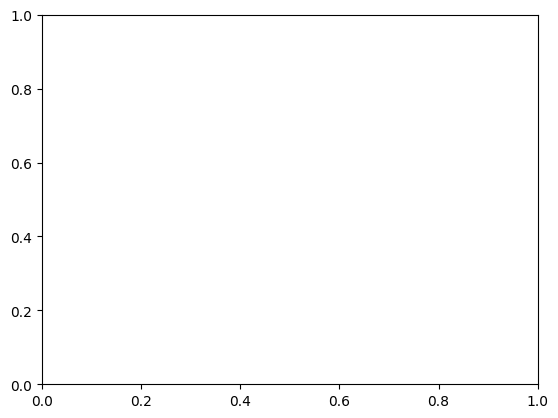

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
X = jnp.array(X)
y = jnp.array(y).reshape(-1, 1)
# Definir x1 y x2
x1 = jnp.linspace(-1.1, 2.1, 100)
x2 = jnp.linspace(-0.6, 1.1, 100)

# Crear la malla de valores X1, X2
X1, X2 = jnp.meshgrid(x1, x2)
X_grid = jnp.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)

# Calcular las predicciones usando la función sigmoidal (asegúrate de tener 'features' y 'weights' definidos previamente)
y_pred = sigmoid(features, weights)  # Corregido: usar dot product para multiplicar 'X_grid' y 'weights'

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots()

# Dibujar un contorno relleno (regiones) según las predicciones
ax.contourf(X1, X2, y_pred.reshape(X1.shape), cmap="RdBu", alpha=0.3)

# Dibujar puntos dispersos según los valores en 'X' y su etiqueta 'y'
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", alpha=0.3)  # Asumiendo que tienes 'X' y 'y' definidos

# Configurar etiquetas de ejes
ax.set(xlabel="X1", ylabel="X2")  # Agregar etiquetas descriptivas a los ejes

# Mostrar el gráfico
plt.show()
